>参考：<br/>AlexeyAB的repo [how-to-train-to-detect-your-custom-objects](https://github.com/AlexeyAB/darknet#how-to-train-to-detect-your-custom-objects)<br/>油管博主AI Guy [YOLOv3 in the CLOUD : Install and Train Custom 
Object Detector (FREE GPU)](https://www.youtube.com/watch?v=10joRJt39Ns&t=370s)<br/> 以及B站UP主 阿黎好帅 [在Colab上训练自己的YOLOv3模型（二）](https://www.bilibili.com/video/BV19T4y137AS)







# 第一步：开启GPU加速
Colab默认是没开启GPU加速的，我们点击【修改】【笔记本设置】【硬件加速】【GPU】


# 第二步：加载DarkNet
加载网络
开启GPU和OPENCV


In [0]:
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 13524, done.
remote: Total 13524 (delta 0), reused 0 (delta 0), pack-reused 13524
Receiving objects: 100% (13524/13524), 12.17 MiB | 12.10 MiB/s, done.
Resolving deltas: 100% (9242/9242), done.


使用cudnn和opencv

In [0]:
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile

/content/darknet


In [0]:
# 看下CUDA
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [0]:
# 编译DarkNet，不用管警告
!make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:910:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void cv_draw_object(image, float*, int, int, int*, float*, int*, int, char**)’:
./src/image_opencv.cpp:1391:14: warning: unused variable ‘buff’ [-Wunused-variable]
         char buff[100];
              ^~~~
./src/image_opencv.cpp:1367:9: warning: unused variable ‘it_tb_res’ [-W

定义几个函数备用

In [0]:
# 显示
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

# 上传文件
def upload():
  from google.colab import files
  uploaded = files.upload() 
  for name, data in uploaded.items():
    with open(name, 'wb') as f:
      f.write(data)
      print ('saved file', name)

# 下载文件 
def download(path):
  from google.colab import files
  files.download(path)

挂载一下谷歌云盘，把Google Drive作为vm的硬盘

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


不是很方便，新建一个软连接

In [0]:
# 这其实就是一个连接
!ln -s /content/drive/My\ Drive/ /mydrive
!ls /mydrive

'Colab Notebooks'     det.jpg   LSB		     test.txt	 yolov3.weights
 detector.c	      foo.txt  'Sample file'	     train.txt
 detector_oringin.c   images   'Sample upload.txt'   yolov3


# 第三步：加载自己的数据集

先在云盘上传obj.zip

In [0]:
!ls /mydrive/yolov3

backup		   Makefile   obj_origin.zip  train.txt
darknet53.conv.74  obj.data   obj.zip	      yolov3_custom3.cfg
generate_train.py  obj.names  test.txt


从云盘复制到根目录

In [0]:
# 搞到根目录
!cp /mydrive/yolov3/obj_v2.zip ../

In [0]:
# 解压缩
!unzip ../obj_v2.zip -d ./data/obj

然后修改yolov3.cfg

In [0]:
# 下载到drive并重命名
!cp cfg/yolov3.cfg /mydrive/yolov3/yolov3_custom3.cfg

In [0]:
# 下载到本地
download('cfg/yolov3.cfg')


修改完后复制回去

In [0]:
!cp /mydrive/yolov3/yolov3_custom3.cfg ./cfg

In [0]:
# 从drive上传obj.names 和 obj.data 
!cp /mydrive/yolov3/obj.data  ./data

In [0]:
!cp /mydrive/yolov3/obj.names  ./data

编写generate_train.py并上传


In [0]:
!cp /mydrive/yolov3/generate_train.py ./

In [0]:
#生成train.txt
!python generate_train.py

In [0]:
!cp data/train.txt /mydrive/

In [0]:
!ls data/

9k.tree     eagle.jpg	 imagenet.labels.list	   obj.data	     scream.jpg
coco9k.map  giraffe.jpg  imagenet.shortnames.list  obj.names	     train.txt
coco.names  goal.txt	 labels			   openimages.names  voc.names
dog.jpg     horses.jpg	 obj			   person.jpg


下载预训练的卷积层权重

In [0]:
# 下载卷积层,但是网速比较慢，可以先从其他源下载上传到Google Drive，再按下面的方法复制
!wget http://pjreddie.com/media/files/darknet53.conv.74

--2020-05-19 09:15:47--  http://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pjreddie.com/media/files/darknet53.conv.74 [following]
--2020-05-19 09:15:47--  https://pjreddie.com/media/files/darknet53.conv.74
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘darknet53.conv.74.1’

darknet53.conv.74.1  20%[===>                ]  31.71M   120KB/s    eta 14m 38s^C


In [0]:
#如果有了，下次可以从云盘直接复制
!cp /mydrive/yolov3/darknet53.conv.74 ./

这些部分是为了修改train,test,config的操作

In [0]:
!cp /mydrive/train.txt ./data/train.txt

In [0]:
!cp /mydrive/test.txt ./data/test.txt

In [0]:
!cp /mydrive/yolov3/yolov3_custom4.cfg cfg/

In [0]:
!cp /mydrive/yolov3/backup/yolov3_custom3_last.weights ./

In [0]:
!cp /mydrive/yolov3/yolov3_custom4.cfg cfg/

In [0]:
!rm cfg/yolov3_custom4.cfg

In [0]:
!cp /mydrive/test/test.txt ./data/test.txt

In [0]:
!cp /mydrive/test/fpC-001035-gr2-0011.jpg ./data/obj/

# 第四步：开始训练

In [0]:
# 开始train，要很久
!./darknet detector train data/obj.data cfg/yolov3_custom3.cfg darknet53.conv.74 -dont_show 

训练过程中，由于屏幕失焦太久，Colab会自动断开，在浏览器Console中输入如下js语句防止自动断开


```
function ClickConnect(){
  console.log("Connnect Clicked - Start"); 
  document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click();
  console.log("Connnect Clicked - End"); 
};
setInterval(ClickConnect, 60000)
```
来源：[StackOverflow: How to prevent Google Colab from disconnecting?](https://stackoverflow.com/questions/57113226/how-to-prevent-google-colab-from-disconnecting)



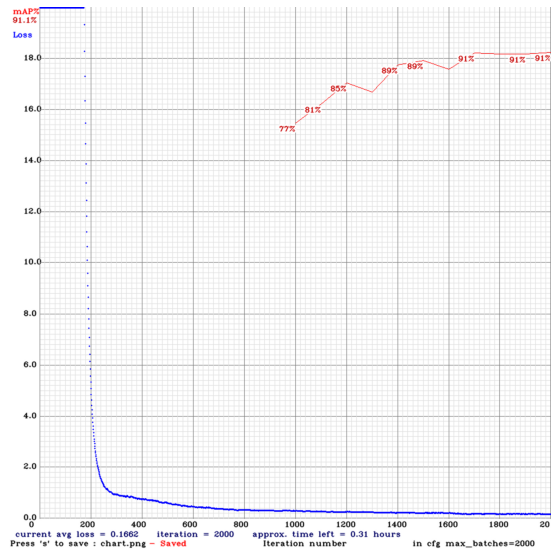

In [0]:
#train完之后，显示一下loss图
imShow("chart.png")
download("chart.png")

In [0]:
# 如果因为各种原因中断了，可以从上次保存的权重开始训练（每100epochs保存1一次）
!./darknet detector train data/obj.data cfg/yolov3_custom3.cfg /mydrive/yolov3/backup/yolov3_custom3_last.weights -dont_show

In [0]:
# 切换到检测模式
%cd cfg
!sed -i 's/batch=64/batch=1/' yolov3_custom3.cfg
!sed -i 's/subdivisions=16/subdivisions=1/' yolov3_custom3.cfg
%cd ..

/content/darknet/cfg
/content/darknet


In [0]:
#有的时候也想继续训练
%cd cfg
!sed -i 's/batch=1/batch=64/' yolov3_custom4.cfg
!sed -i 's/subdivisions=1/subdivisions=16/' yolov3_custom4.cfg
%cd ..

/content/darknet/cfg
/content/darknet


# 第五步：检测与评估

 CUDA-version: 10010 (10010), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,  wt = 0, wn = 0, outputs: 104 x 104 x 128 0.001 B

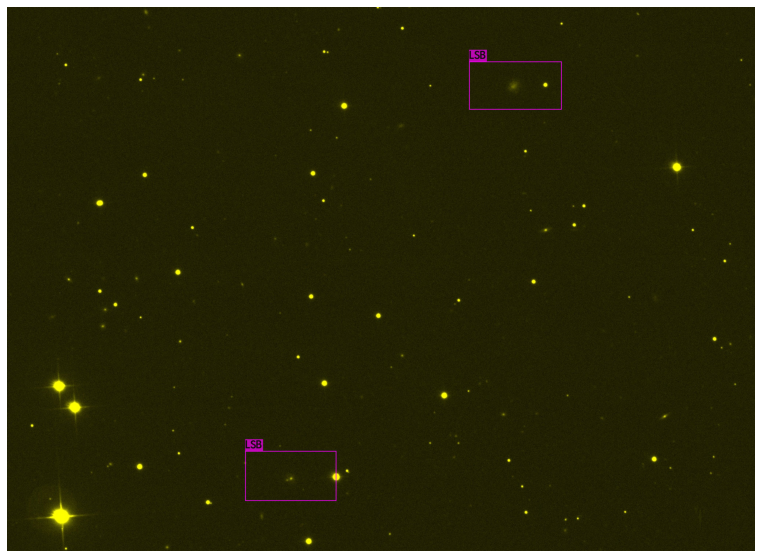

In [0]:
# 运行就好，从本地或者云端
!./darknet detector test data/obj.data cfg/yolov3_custom3.cfg /mydrive/yolov3/backup/yolov3_custom3_final.weights /mydrive/test/fpC-001035-gr2-0011.jpg -thresh 0.3
imShow('predictions.jpg')
download('predictions.jpg')

In [0]:
!./darknet detector test data/obj.data cfg/yolov3_custom3.cfg /mydrive/yolov3/backup/yolov3_custom3_final.weights -dont_show -ext_output < data/test.txt > result.txt

In [0]:
!./darknet detector map data/obj.data cfg/yolov3_custom4.cfg /mydrive/yolov3/backup/yolov3_custom4_final.weights

In [0]:
!./darknet detector recall data/obj.data cfg/yolov3_custom4.cfg /mydrive/yolov3/backup/yolov3_custom4_final.weights -out recall.txt

In [0]:
!./darknet detector valid data/obj.data cfg/yolov3_custom3.cfg /mydrive/yolov3/backup/yolov3_custom3_final.weights -out detect_result.txt

最后，可以修改/src/detector.c 改变输出格式，但改完之后记得make clean & make